In [1]:
import gzip
import json

In [2]:
fname = "file_metadata.json.gz"

with gzip.open(fname) as f:
    content = json.loads(f.read().decode())

In [3]:
sum_nfiles_input = 0
sum_size_input_GB = 0
sum_nevts_input = 0

sum_nfiles_output = 0
sum_size_output_GB = 0

sizes_output_GB = []
avg_sizes_output_GB = []
nfiles_output = []


for category_info in content.values():
    for dataset_info in category_info.values():
        sum_nfiles_input += dataset_info["nfiles_input"]
        sum_size_input_GB += dataset_info["size_input_GB"]
        sum_nevts_input += dataset_info["nevts_input"]

        if dataset_info["nfiles_output"] is not None:  # skip missing tasks
            sum_nfiles_output += dataset_info["nfiles_output"]
            sum_size_output_GB += dataset_info["size_output_GB"]
            sizes_output_GB.append(dataset_info["size_output_GB"])
            avg_sizes_output_GB.append(dataset_info["size_output_GB"] / dataset_info["nfiles_output"])
            nfiles_output.append(dataset_info["nfiles_output"])

print("PHYSLITE INPUT")
print(f"  nfiles:    {sum_nfiles_input:,}")
print(f"  size [GB]: {sum_size_input_GB:,.0f}")
print(f"  nevents:   {sum_nevts_input:,}")

print("NTUPLE OUTPUT")
print(f"  nfiles:    {sum_nfiles_output:,}")
print(f"  size [GB]: {sum_size_output_GB:,.0f}")

PHYSLITE INPUT
  nfiles:    877,199
  size [GB]: 566,120
  nevents:   59,251,746,268
NTUPLE OUTPUT
  nfiles:    9,287
  size [GB]: 21,254


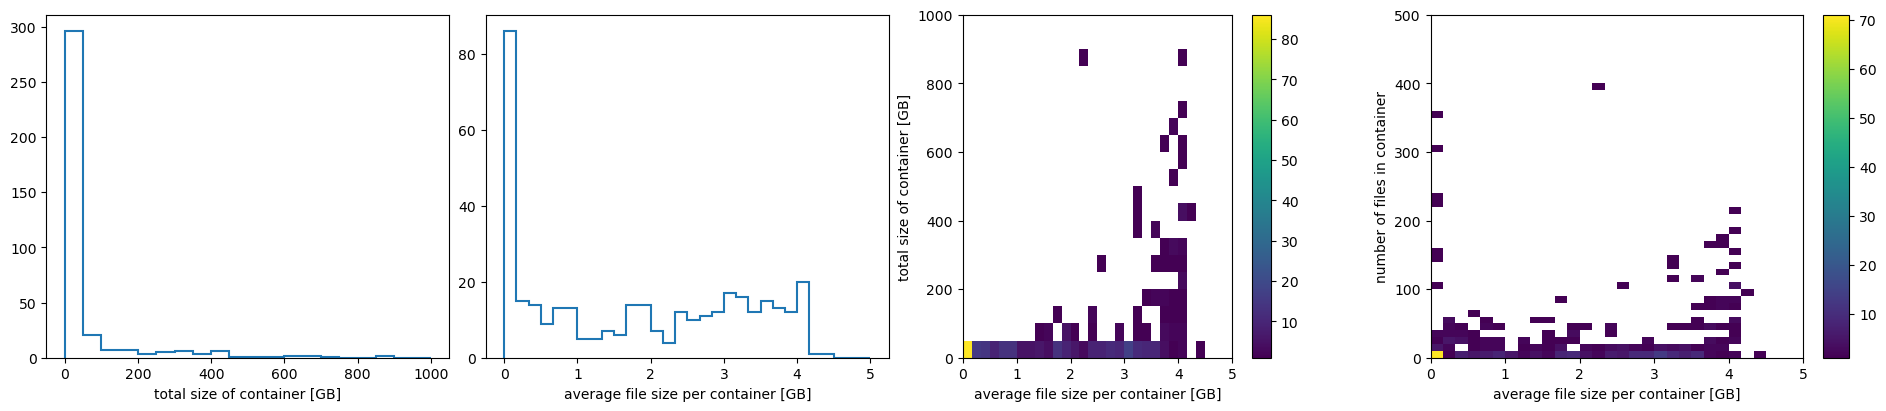

In [4]:
import hist
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(16, 4), ncols=4, constrained_layout=True)

hist.new.Regular(20, 0, 1_000, label="total size of container [GB]").Double().fill(sizes_output_GB).plot(ax=ax1, yerr=False)
h = hist.new.Regular(30, 0, 5, label="average file size per container [GB]").Double().fill(avg_sizes_output_GB).plot(ax=ax2, yerr=False)

h = hist.new.Regular(30, 0, 5, label="average file size per container [GB]").Regular(20, 0, 1_000, label="total size of container [GB]").Double()
_ = h.fill(avg_sizes_output_GB, sizes_output_GB).plot(ax=ax3, cmin=1)

h = hist.new.Regular(30, 0, 5, label="average file size per container [GB]").Regular(50, 0, 500, label="number of files in container").Double()
_ = h.fill(avg_sizes_output_GB, nfiles_output).plot(ax=ax4, cmin=1)